In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../..')

In [2]:
import os
import pandas as pd
from src.utils.preprocess import preprocess_video, split_video, split_audio
import librosa
from datetime import datetime
from src.utils.model import get_audio_model, get_visual_model, find_ckpt
from src.utils.transforms import get_video_transforms
from src.utils.engine import yaml_search, get_recording_filename, read_frames, get_recording_paths, predict, predict_with_files

In [3]:

cwd = f"{os.getcwd()}/../../src/resources"
run_model = 48
# 3434 - ambil sepuluh telepon merah di kantor
rid = 3435
experiment = yaml_search(f"{cwd}/experiments/video", run_model)

hparams = experiment["hyperparameters"]
config = experiment["config"]
data = experiment["data"]

seed, batch_size, learning_rate = hparams["seed"], hparams["batch_size"], float(hparams["learning_rate"])
model_conf = experiment["model"]
config = experiment["config"]
data = experiment["data"]
transforms = get_video_transforms(data["transform"], data["color"])

visual_model = get_visual_model(model_conf["version"], learning_rate, model_conf["name"], experiment)
audio_model = get_audio_model(data["audio_version"], learning_rate, data["audio_run"])

# Filenames for Target
dt = datetime.now()
time = int(dt.strftime("%Y%m%d%H%M%S"))
filepath = f"{cwd}/results"
filename = f"{time}"
filename_prediction = f"{filename}_Prediction.MP4"
filepath_prediction = f"{filepath}/{filename_prediction}"
filename_latent = f"{filename}_Latent.MP4"
filepath_latent = f"{filepath}/{filename_latent}"
filename_ori = f"{filename}_Original.MP4"
filepath_ori = f"{filepath}/{filename_ori}"


def load_model(model, cwd, _type, frames, run_name):
    default_ckpt_path = f"{cwd}/models/ilmsg-{_type}/f{frames}"
    ckpt_filename = find_ckpt(f"{default_ckpt_path}/{run_name}/")
    ckpt_path = f"{default_ckpt_path}/{run_name}/{ckpt_filename}"
    model = model.load_from_checkpoint(ckpt_path).cuda()
    return model

# Load Audio CKPT
audio_model = load_model(audio_model, cwd, "audio", data["frames"], data["audio_run"])
# Load Video CKPT
visual_model = load_model(visual_model, cwd, "video", data["frames"], model_conf["name"])

recordings = pd.read_json(f"{cwd}/config/recordings.json")
recording = recordings[recordings["rid"] == int(rid)]
speakers = pd.read_csv(f"{cwd}/config/speakers.csv", delimiter=";")
speaker = speakers[speakers["id"] == recording["spid"].item()]
gender = "pria" if speaker['gender'].item() == "L" else "wanita"

processed_dir = f"{cwd}/data/processed"
interim_dir = f"{cwd}/data/interim/{gender}"
raw_video_dir = f"{interim_dir}/video/raw"
audio_dir = f"{interim_dir}/audio"

arr_size = str(data["frame_size"]).split("x")
color = "" if not data["color"] else "-color"
if len(arr_size) == 1:
    arr_size = [int(arr_size[0]), int(arr_size[0])]
else:
    arr_size = [int(arr_size[0]), int(arr_size[1])]

print(raw_video_dir)
recording_filename = get_recording_filename(rid, raw_video_dir).split(".")[0]
ori_video_filename = f"{recording_filename}.MP4"
ori_audio_filename = f"{recording_filename}.WAV"

ori_audio_path = f"{audio_dir}/{ori_audio_filename}"
ori_audio, _ = librosa.load(ori_audio_path, sr=16000)

ori_video_path = f"{raw_video_dir}/{ori_video_filename}"
ori_video, (h, w) = read_frames(ori_video_path, True)

video_dir = f"{processed_dir}/{data['size']}x/seed-{seed}/{gender}/video/{arr_size[0]}x{arr_size[1]}{color}/F{data['frames']}"
label_dir = f"{processed_dir}/{data['size']}x/seed-{seed}/{gender}/label/mels-{data['n_mels']}/{data['audio_run']}/F{data['frames']}"
video_files, label_files = [], []
if os.path.isdir(video_dir) and os.path.isdir(label_dir):
    label_files = get_recording_paths(rid, label_dir)
    video_files = get_recording_paths(rid, video_dir)

(ori_mels, ori_latent, ori_audio), (target_mels, target_latent, target_wav) = predict_with_files(
                video_files=video_files,
                filepaths=(filepath_prediction, filepath_latent, filepath_ori),
                transforms=transforms,
                ori_video=ori_video,
                label_files=label_files,
                audio_model=audio_model,
                visual_model=visual_model,
                ori_audio=ori_audio
            )

d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/data/interim/pria/video/raw
Moviepy - Building video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Prediction.MP4.
MoviePy - Writing audio in 20230518201912_PredictionTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Prediction.MP4



Moviepy - Done !
Moviepy - video ready d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Prediction.MP4
Moviepy - Building video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Latent.MP4.
MoviePy - Writing audio in 20230518201912_LatentTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Latent.MP4



Moviepy - Done !
Moviepy - video ready d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Latent.MP4
Moviepy - Building video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Original.MP4.
MoviePy - Writing audio in 20230518201912_OriginalTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Original.MP4



Moviepy - Done !
Moviepy - video ready d:\College\Tugas_Akhir\ILMSG-Webservice\src\notebook/../../src/resources/results/20230518201912_Original.MP4


In [4]:
from src.visualization.audio import visualize_mels, visualize_latent, compare_audio,visualize_audio

52400


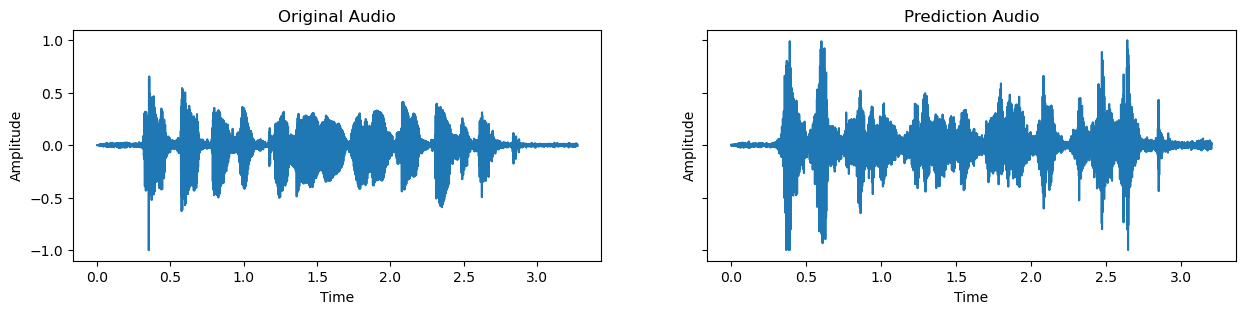

In [5]:
# Ambil sepuluh telepon merah di kantor
compare_audio(ori_audio,target_wav, 16000.0, f"Prediction")

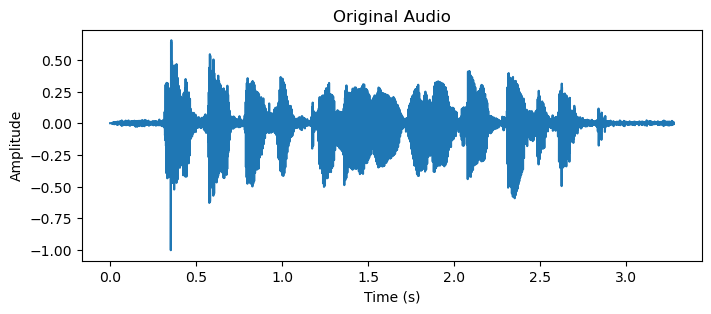

In [6]:
visualize_audio(ori_audio, desc="Original Audio")

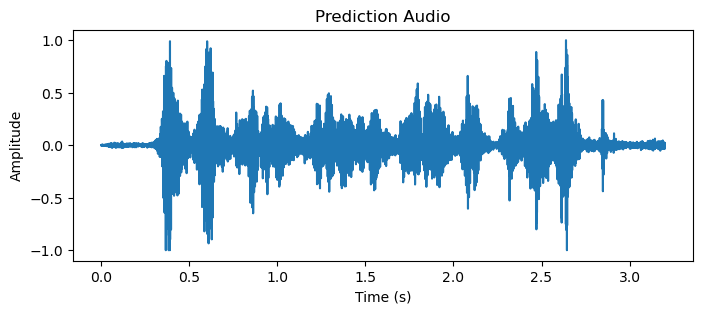

In [7]:
visualize_audio(target_wav, desc="Prediction Audio")

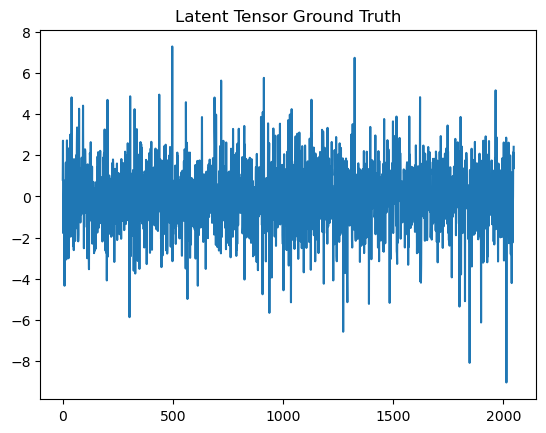

In [16]:
visualize_latent(ori_latent[1], save=False, vmax=ori_latent.max(), vmin=ori_latent.min(),desc="Ground Truth")

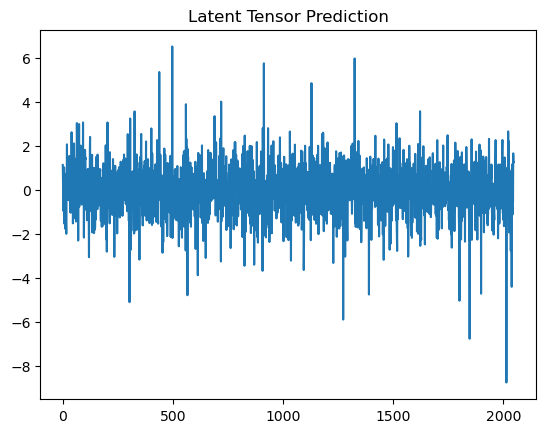

In [15]:
visualize_latent(target_latent[1], save=False, vmax=target_latent.max(), vmin=target_latent.min(), desc="Prediction")

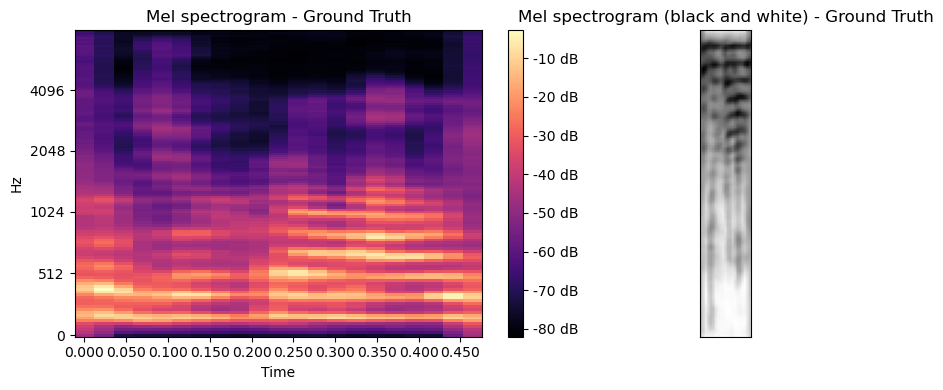

In [14]:
visualize_mels(
    mels=ori_mels[1].squeeze().detach().cpu().numpy(),
    save=False,
    truth=True,
    from_db=True
)

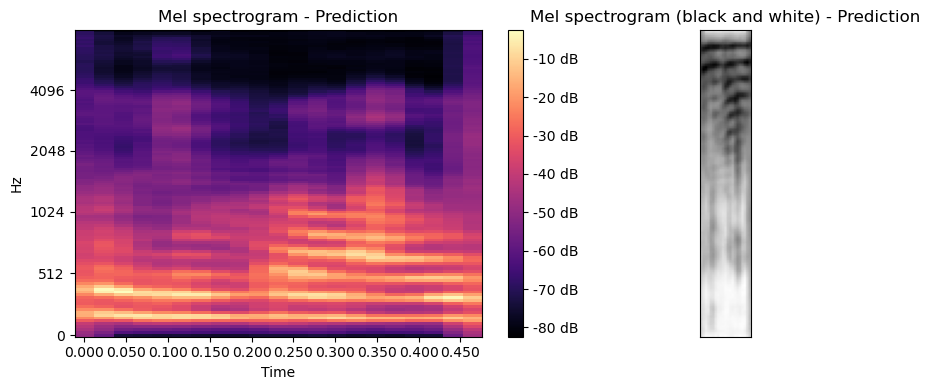

In [13]:
visualize_mels(
    mels=target_mels[1].squeeze().detach().cpu().numpy(),
    save=False,
    truth=False,
    from_db=True
)

In [52]:
target_mels.squeeze().detach().cpu().shape

torch.Size([4, 128, 21])

In [12]:
import soundfile as sf
sf.write("R3435_ORI.WAV", ori_audio, samplerate=16000)
sf.write("R3435_PRED.WAV", target_wav, samplerate=16000)